In [ ]:
import scipy.io
from google.colab import drive
drive.mount('/content/drive/')
input = scipy.io.loadmat("/content/drive/MyDrive/Data/HW/ctscan_hw1.mat")

In [ ]:
import numpy as np
ct_scans = input['ctscan']
ct_scans = np.array(ct_scans)
ct_scans = np.swapaxes(ct_scans,0,2)
ct_scans = np.swapaxes(ct_scans,1,2)
print(ct_scans.shape)

In [ ]:
input = scipy.io.loadmat("/content/drive/MyDrive/Data/HW/infmsk_hw1.mat")
mask = input['infmsk']
mask = np.array(mask)
mask = np.swapaxes(mask,0,2)
mask = np.swapaxes(mask,1,2)
print(mask.shape)

In [ ]:
mask=mask[2000:2020,:,:]
ct_scans=ct_scans[2000:2020,:,:]
size = ct_scans.shape[0]
print(size)

In [20]:
from sklearn.cluster import KMeans 
from numpy.ma.core import argsort
pred_masks = []
a=ct_scans.shape[1]
b=ct_scans.shape[2]
# m=3000
for i in range(ct_scans.shape[0]):
  temp = ct_scans[i]/255
  kmeans = KMeans(n_clusters=3, random_state=0)
  clusters = kmeans.fit_predict(temp.reshape(a*b,1))
  temp_pred_mask = clusters.reshape((512,512))
  copy=temp_pred_mask
  ct=[]
  ct.append(np.count_nonzero(temp_pred_mask[:,:] == 0))
  ct.append(np.count_nonzero(temp_pred_mask[:,:] == 1))
  ct.append(np.count_nonzero(temp_pred_mask[:,:] == 2))

  max_val=max(ct)
  b1=ct.index(max_val)
  mask1=(temp_pred_mask==b1)
  copy[mask1]=0

  min_val=min(ct)
  b2=ct.index(min_val)
  mask2=(temp_pred_mask==b2)
  copy[mask2]=1

  b3=3-b1-b2
  mask3=(temp_pred_mask==b3)
  copy[mask3]=2

  pred_masks.append(copy)

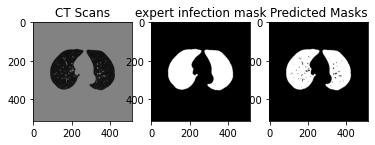

In [22]:
import matplotlib.pyplot as plt
index_1=5
index_2=9
f, plot = plt.subplots(1,3)
plot[0].set_title("CT Scans")
plot[0].imshow(ct_scans[index_1], cmap='gray')
plot[1].set_title("expert infection mask")
plot[1].imshow(mask[index_1], cmap='gray')
plot[2].set_title("Predicted Masks")
plot[2].imshow(pred_masks[index_1], cmap='gray')

plt.show()

Dice score, sensitivity, specificity, and accuracy for the normal and
infected regions

In [25]:
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')
def give_metrics(y, y_pred):

  N = y_pred.shape[0]
  total_infection_sensitivity = 0
  total_infection_specificity = 0
  total_infection_accuracy = 0
  total_infection_dice_score = 0
  
  total_normal_sensitivity = 0
  total_normal_specificity = 0
  total_normal_accuracy = 0
  total_normal_dice_score = 0

  count_infection_sensitivity = 0               

  for i in range(y_pred.shape[0]):
    infection_sensitivity = 0
    #Getting confusion matrix
    confusion_metric = (confusion_matrix(y[i].flatten(), y_pred[i].flatten(),labels=[0,1,2])).T

    #Getting TP/FP/FN/TN
    TP_infection = confusion_metric[1][1]
    TP_normal = confusion_metric[2][2]

    TN_infection = confusion_metric[0][0] + confusion_metric[2][0] + confusion_metric[0][2] + confusion_metric[2][2]
    TN_normal = confusion_metric[0][0] + confusion_metric[0][1] + confusion_metric[1][0] + confusion_metric[1][1]
    
    FP_infection = confusion_metric[1][0] + confusion_metric[1][2]
    FP_normal = confusion_metric[2][0] + confusion_metric[2][1] 

    FN_infection = confusion_metric[0][1] + confusion_metric[2][1]
    FN_normal = confusion_metric[0][2] + confusion_metric[1][2]
        
    #calculating metrics    
    infection_specificity = (TN_infection)/(TN_infection+FP_infection)
    infection_accuracy = (TP_infection+TN_infection)/(TP_infection+TN_infection+FP_infection+FN_infection)
    infection_dice_score = (2*TP_infection)/(2*TP_infection + FP_infection + FN_infection)

    normal_sensitivity = (TP_normal)/(TP_normal+FN_normal)
    normal_specificity = (TN_normal)/(TN_normal+FP_normal)
    normal_accuracy = (TP_normal+TN_normal)/(TP_normal+TN_normal+FP_normal+FN_normal)
    normal_dice_score = (2*TP_normal)/(2*TP_normal + FP_normal + FN_normal)
    
    if((TP_infection+FN_infection)!=0):
      count_infection_sensitivity += 1
      infection_sensitivity = (TP_infection)/(TP_infection+FN_infection)
    
    # normal_sensitivity = 0
    # if((normal_TP+infectio_FN)!=0):
    #   count_infection_sensitivity += 1
    #   infection_sensitivity = (infection_TP)/(infection_TP+infection_FN)

    total_infection_sensitivity += infection_sensitivity
    total_normal_sensitivity += normal_sensitivity
    total_infection_specificity += infection_specificity
    total_normal_specificity += normal_specificity
    total_infection_accuracy += infection_accuracy
    total_normal_accuracy += normal_accuracy
    total_infection_dice_score += infection_dice_score
    total_normal_dice_score += normal_dice_score
  #finding avg and printing 
  print(f"Averaged dice score = {total_normal_dice_score/N}, sensitivity = {total_normal_sensitivity/N}, \n specificity = {total_normal_specificity/N}, and accuracy = {total_normal_accuracy/N} for the normal")
  print(f"\nAveraged dice score = {total_infection_dice_score/N}, sensitivity = {total_infection_sensitivity/(count_infection_sensitivity+0.0001)}, \n specificity = {total_infection_specificity/N}, and accuracy = {total_infection_accuracy/N} for the infection")

In [ ]:
pred_masks = np.array(pred_masks)
give_metrics(mask, pred_masks)